# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re
import string

import torch
import transformers

from sklearn.preprocessing import LabelEncoder

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

Visão Geral dos dados

In [5]:

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [7]:
df_reviews.corr()

,start_year,is_adult,average_rating,votes,rating,pos,idx
start_year,1.000000,-0.008444,-0.189847,0.095835,-0.187441,-0.181571,-0.002162
is_adult,-0.008444,1.000000,-0.015592,-0.012193,0.004866,0.005168,-0.017616
average_rating,-0.189847,-0.015592,1.000000,0.229570,0.509180,0.481103,-0.019296
votes,0.095835,-0.012193,0.229570,1.000000,0.054170,0.052365,-0.014679
rating,-0.187441,0.004866,0.509180,0.054170,1.000000,0.941231,0.000956
pos,-0.181571,0.005168,0.481103,0.052365,0.941231,1.000000,0.005141
idx,-0.002162,-0.017616,-0.019296,-0.014679,0.000956,0.005141,1.000000


Após uma primeira análise geral dos dados pude tirar algumas conclusões:
- Há apenas 2 dados nulos na coluna ‘average_rating’ e ‘votes’. O que não traz impacto grande para o futuro estudo.
- A coluna ‘runtime_minutes’ está no formato object, apesar de ser uma variável numérica. 
-Nossa variável target ‘pos’ tem grande correlação com a coluna ‘rating, 94% aproximadamente. A única correlação negativa é com a coluna ‘start_year’. 


In [8]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [9]:
for col in df_reviews.columns:
    print(df_reviews[col].value_counts())
    

tt0149151    30
tt0049470    30
tt0162866    30
tt0118749    30
tt0086050    30
             ..
tt0375570     1
tt0114590     1
tt0191198     1
tt0371589     1
tt0247141     1
Name: tconst, Length: 6648, dtype: int64
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: title_type, dtype: int64
The Sentinel             60
The War at Home          54
Emma                     51
Jane Eyre                49
In Cold Blood            42
                         ..
Dead & Buried             1
Voice of the Whistler     1
The Bare-Footed Kid       1
Rambo                     1
The Queen's Sister        1
Name: primary_title, Length: 6555, dtype: int64
The Sentinel           60
The War at Home        54
Emma                   51
Jane Eyre              49
In Cold Blood          42
                       ..
The Lyon's Den      

In [10]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Após rodar o código acima, pude notar que quase todos os dados da coluna ‘end_year’ estão representados pela string /N. Com isso, a coluna acaba não trazendo nenhuma informação relevante. Por isso, mais abaixo, retirei essa coluna do df. 

In [11]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [12]:
#Remoção da coluna ‘end_year’.
df_reviews = df_reviews.drop('end_year',axis=1)

In [13]:
#Remoção das linhas com valores nulos.
df_reviews = df_reviews.dropna(subset=['average_rating','votes'])

In [14]:
#Convertendo coluna ‘runtime_minutes’ para formato correto ‘int’.  
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

In [15]:
#Substituindo valores nulos da coluna ‘runtime_minutes’.
median_runtime = df_reviews['runtime_minutes'].median()
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].fillna(median_runtime)
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype('int')

Abaixo podemos ver nossa tabela após o pré-processamento dos dados. 

In [16]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   runtime_minutes  47329 non-null  int64  
 6   is_adult         47329 non-null  int64  
 7   genres           47329 non-null  object 
 8   average_rating   47329 non-null  float64
 9   votes            47329 non-null  Int64  
 10  review           47329 non-null  object 
 11  rating           47329 non-null  int64  
 12  sp               47329 non-null  object 
 13  pos              47329 non-null  int64  
 14  ds_part          47329 non-null  object 
 15  idx              47329 non-null  int64  
dtypes: Int64(1), float64(1), int64(6), object(8)
memory usage:

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

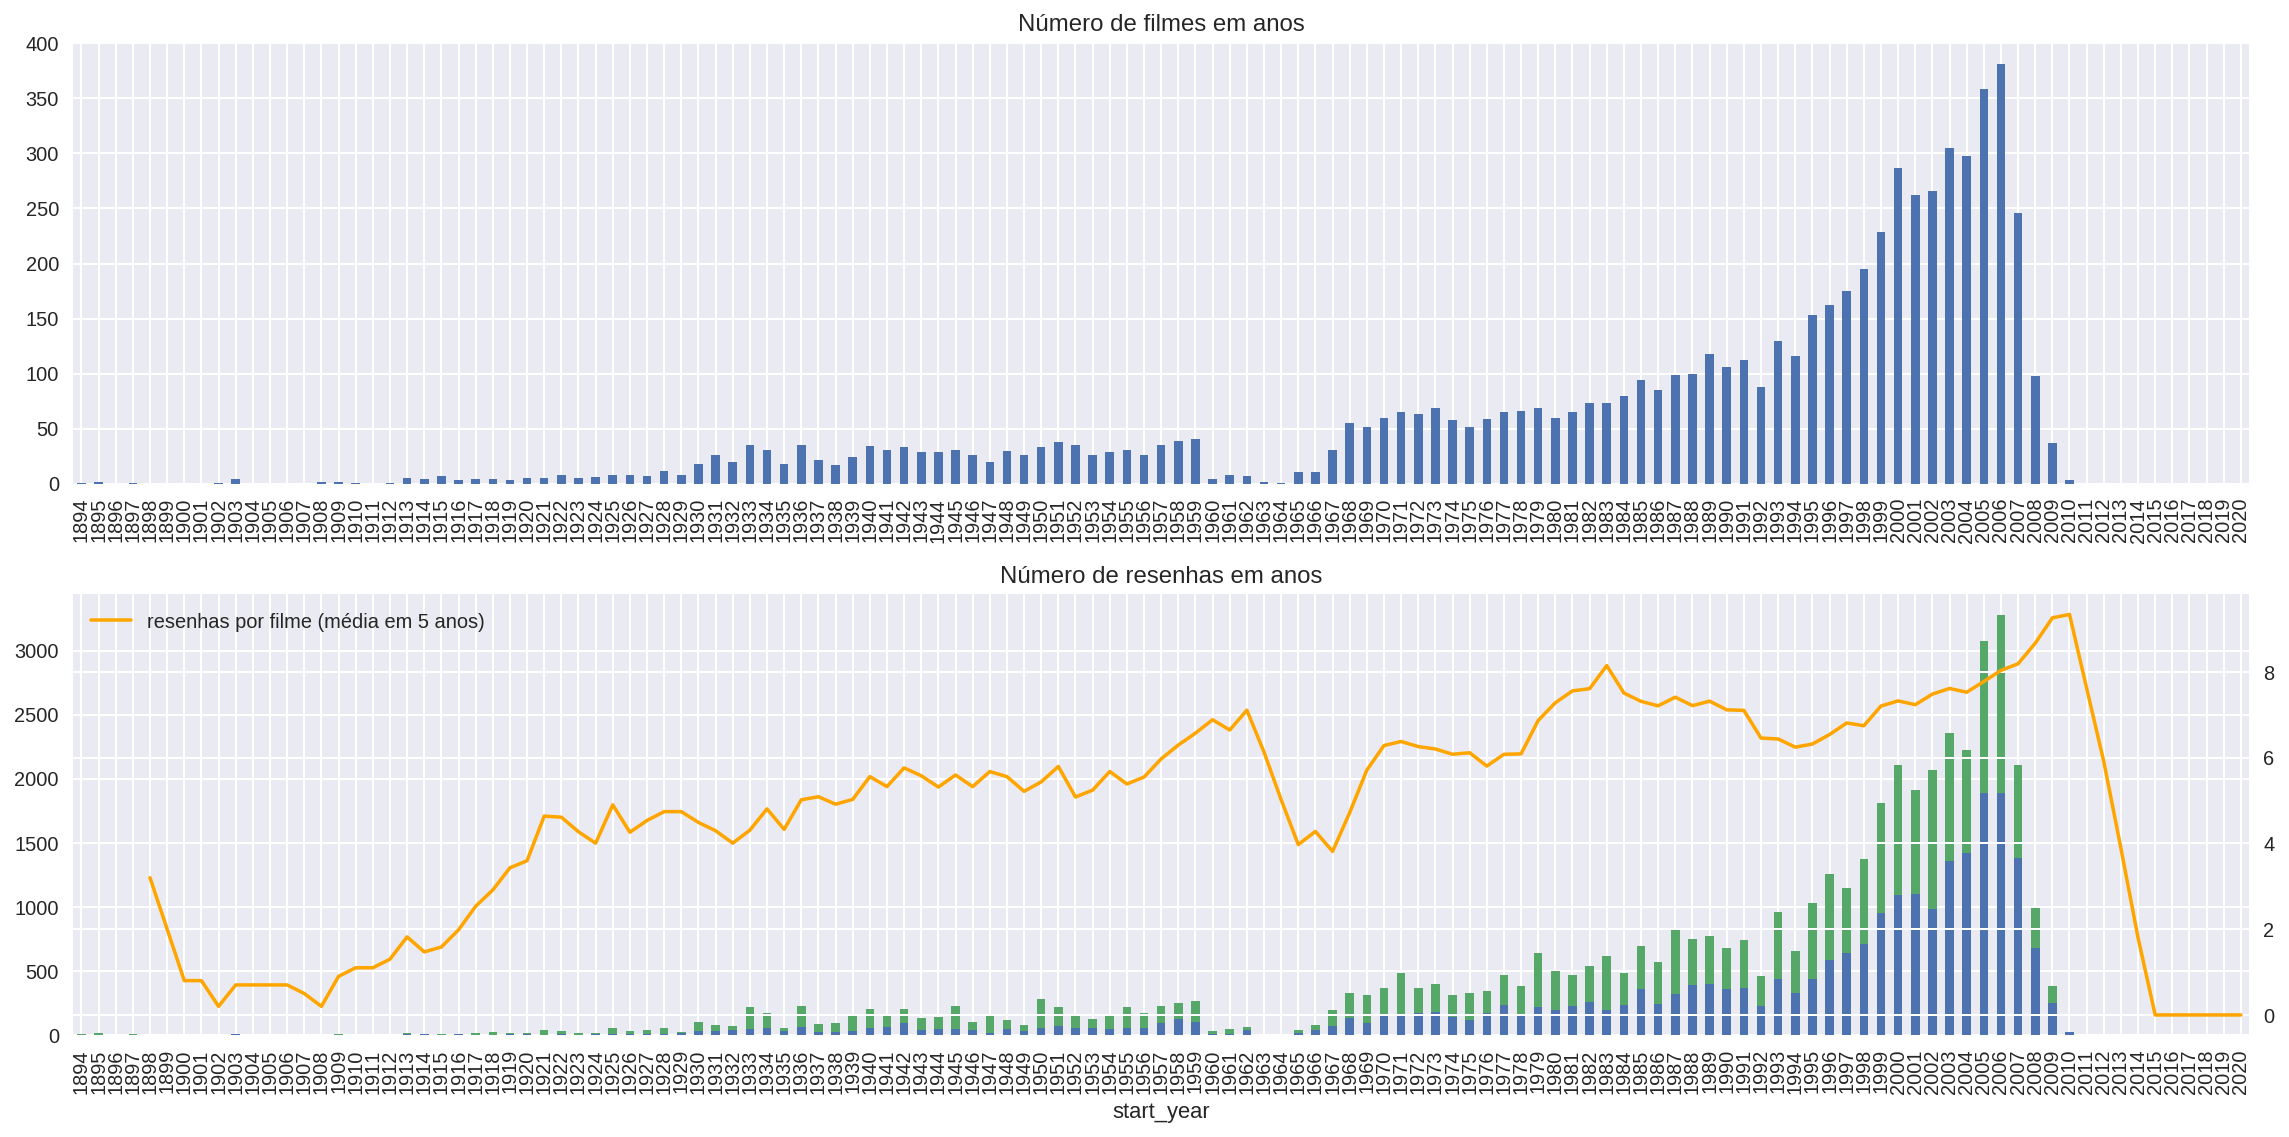

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Percebe-se que o número de resenhas cresce ao longo dos anos, chegando ao ponto máximo no ano de 2006, descendo até 2010, último ano de dados disponíveis. Já a média móvel de resenhas por filme em 5 anos tem um comportamento mais estável. Há um decrescimento entre os anos de 1962 e 1967, porém depois é retomado o comportamento atingindo o máximo em 2010.

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

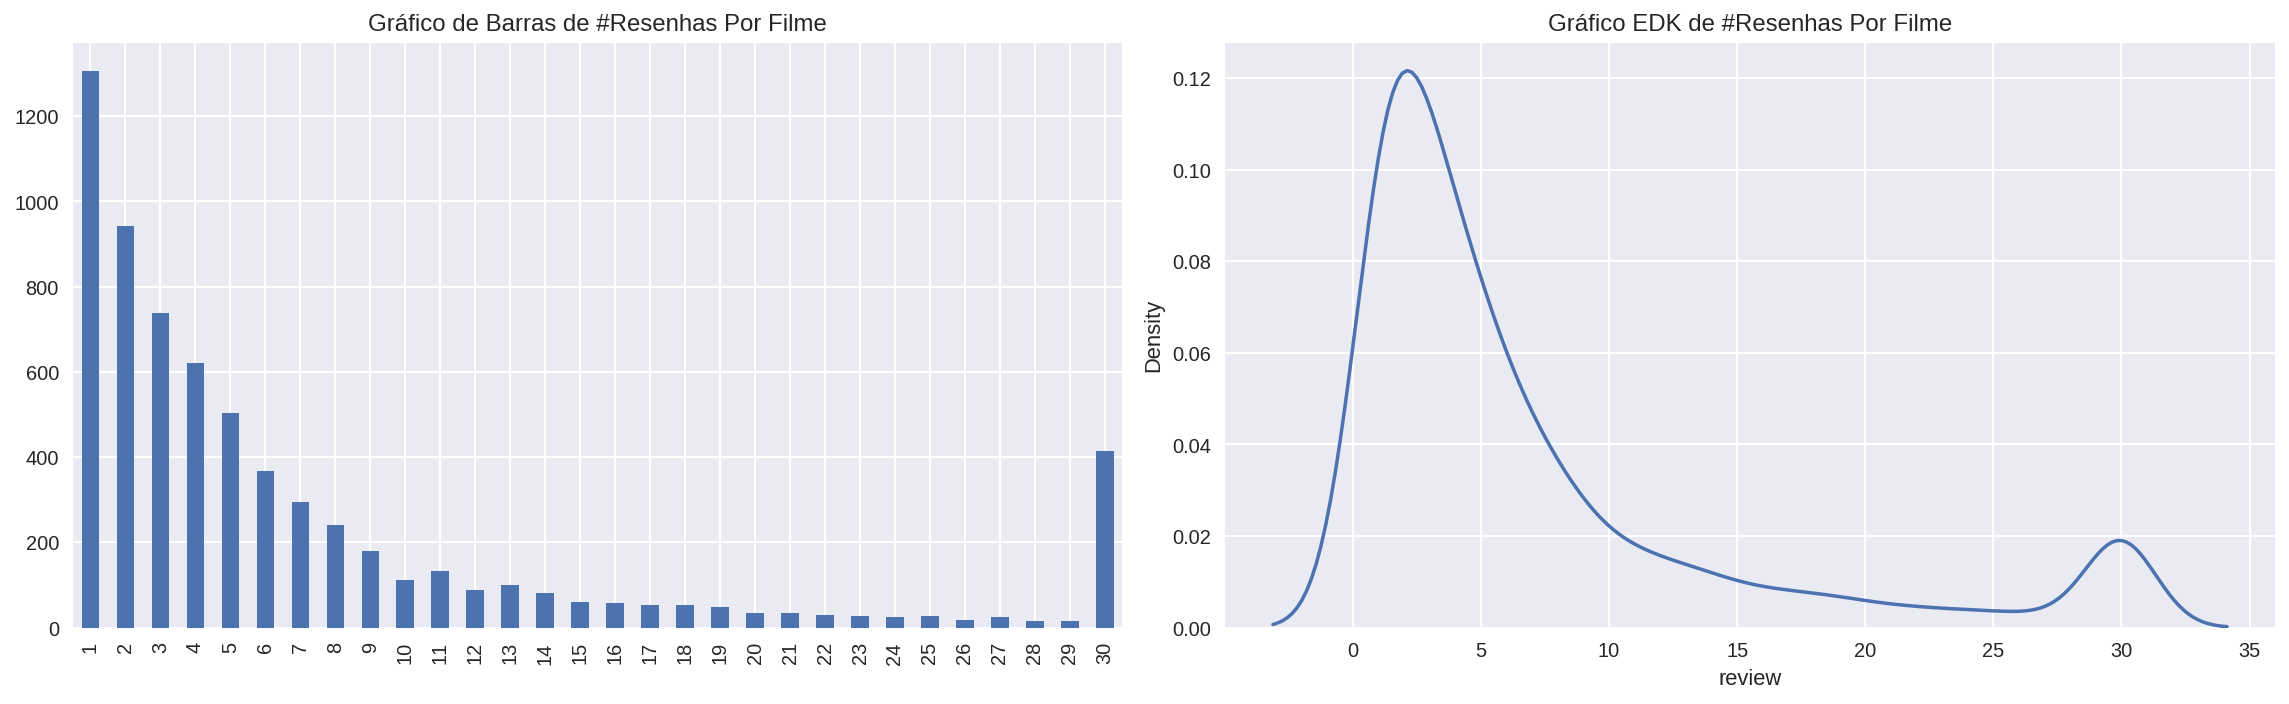

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

A maioria dos filmes tem poucas resenhas, já que a maioria dos filmes da amostra tem apenas 1 resenha, seguindo de 2,3 e 4 resenhas, seguindo um comportamento inversamente proporcional. Curiosos que quando atingimos a marca de 30 resenhas por filme há uma maior concentração, mais de 400 filmes tem 30 resenhas. Talvez a amostra tenha limitado ao máximo de 30 resenhas por filme. O comportamento de ambos os gráficos é bem semelhante.  

In [19]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Quase 50% dos dados são positivos e 50% negativos. Logo a as classes estão balanceadas.  

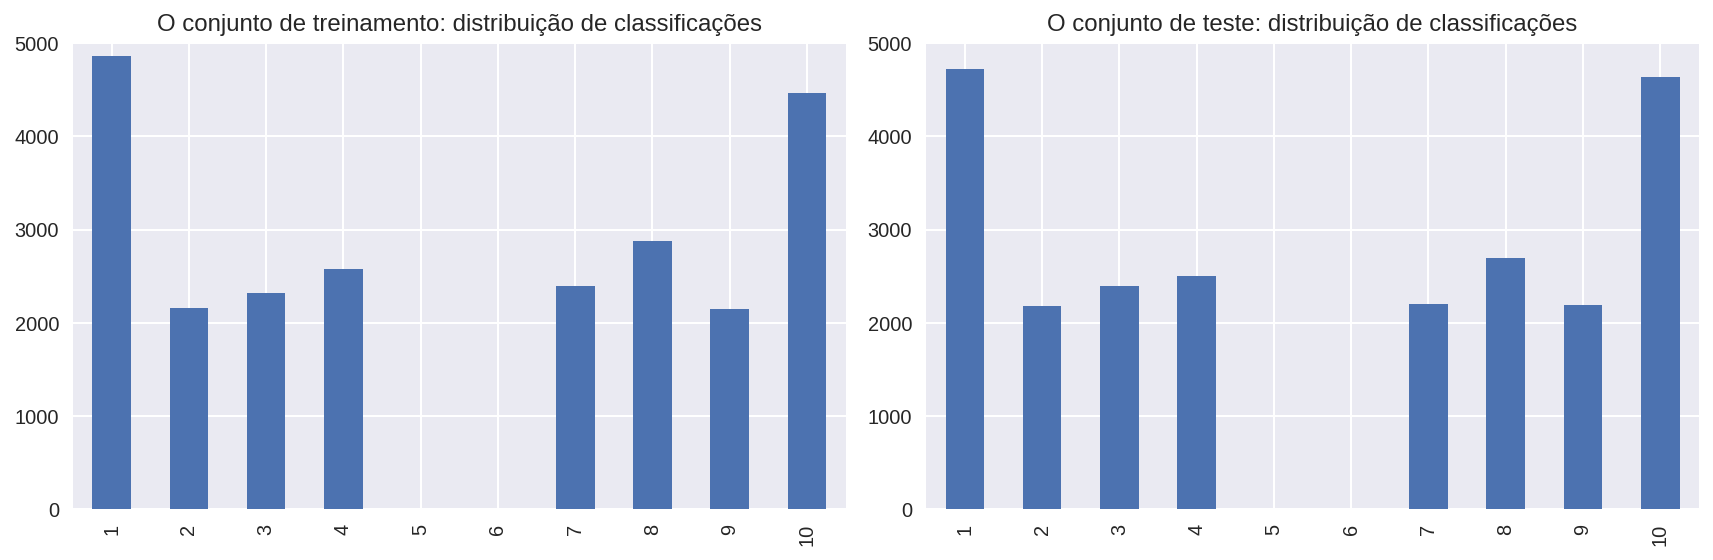

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

A distribuição de classificações do conjunto de treinamento e teste está muito semelhante. Logo as classes estão balanceadas.    

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


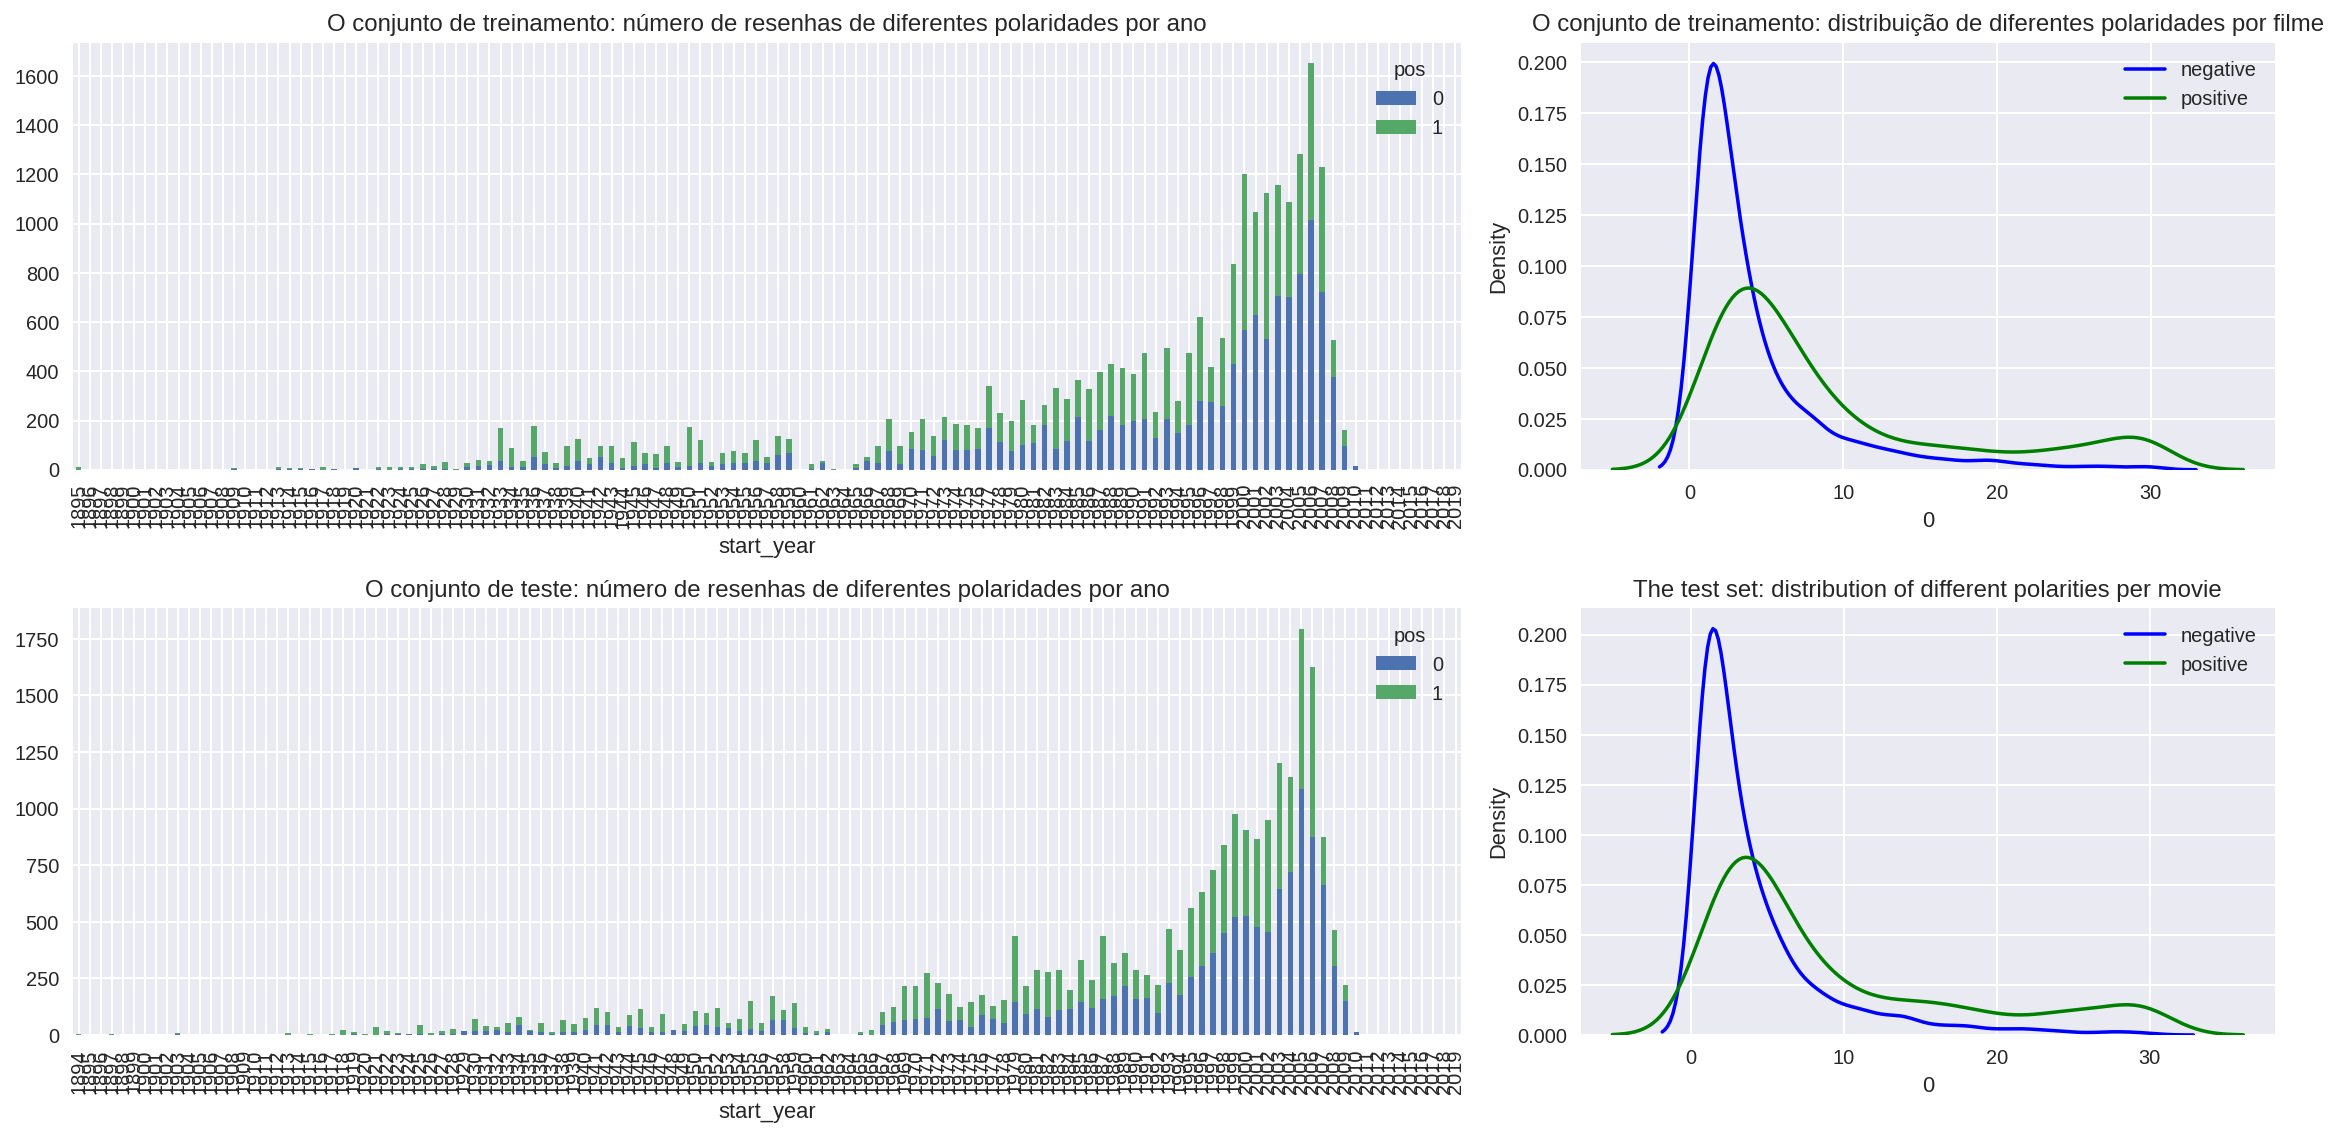

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

A distribuição das resenhas negativas e positivas ao longo dos anos para as duas partes do conjunto de dados está muito semelhante. Logo as classes estão balanceadas.    

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [23]:
#Função para normalização dos textos    
def clear_text(text):
    pattern = r'[^a-zA-z\']'
    clean_text = re.sub(pattern, ' ', text)
    clean_text = " ".join(clean_text.split())
    clean_text = clean_text.lower()
    return clean_text

In [24]:
 # Normalizando as resenhas do dataframe.     
    
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x:clear_text(x)) 

In [25]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23533, 17)


## Trabalhando com modelos

### Modelo 0 - Constante

In [27]:
from sklearn.dummy import DummyClassifier

No modelo DummyClassifier as features não impactam o modelo. Logo escolhi como features o df inteiro.      

In [28]:
train_features_0 = df_reviews_train
test_features_0 = df_reviews_test

In [29]:
model_0 = DummyClassifier(strategy="constant", constant = 1 , random_state = 1235)
model_0.fit(train_features_0, train_target)


DummyClassifier(constant=1, random_state=1235, strategy='constant')

Confesso que não entendi por que F1 e Acurácia deram NaN. Será que a função evaluate_model está com algum problema?

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


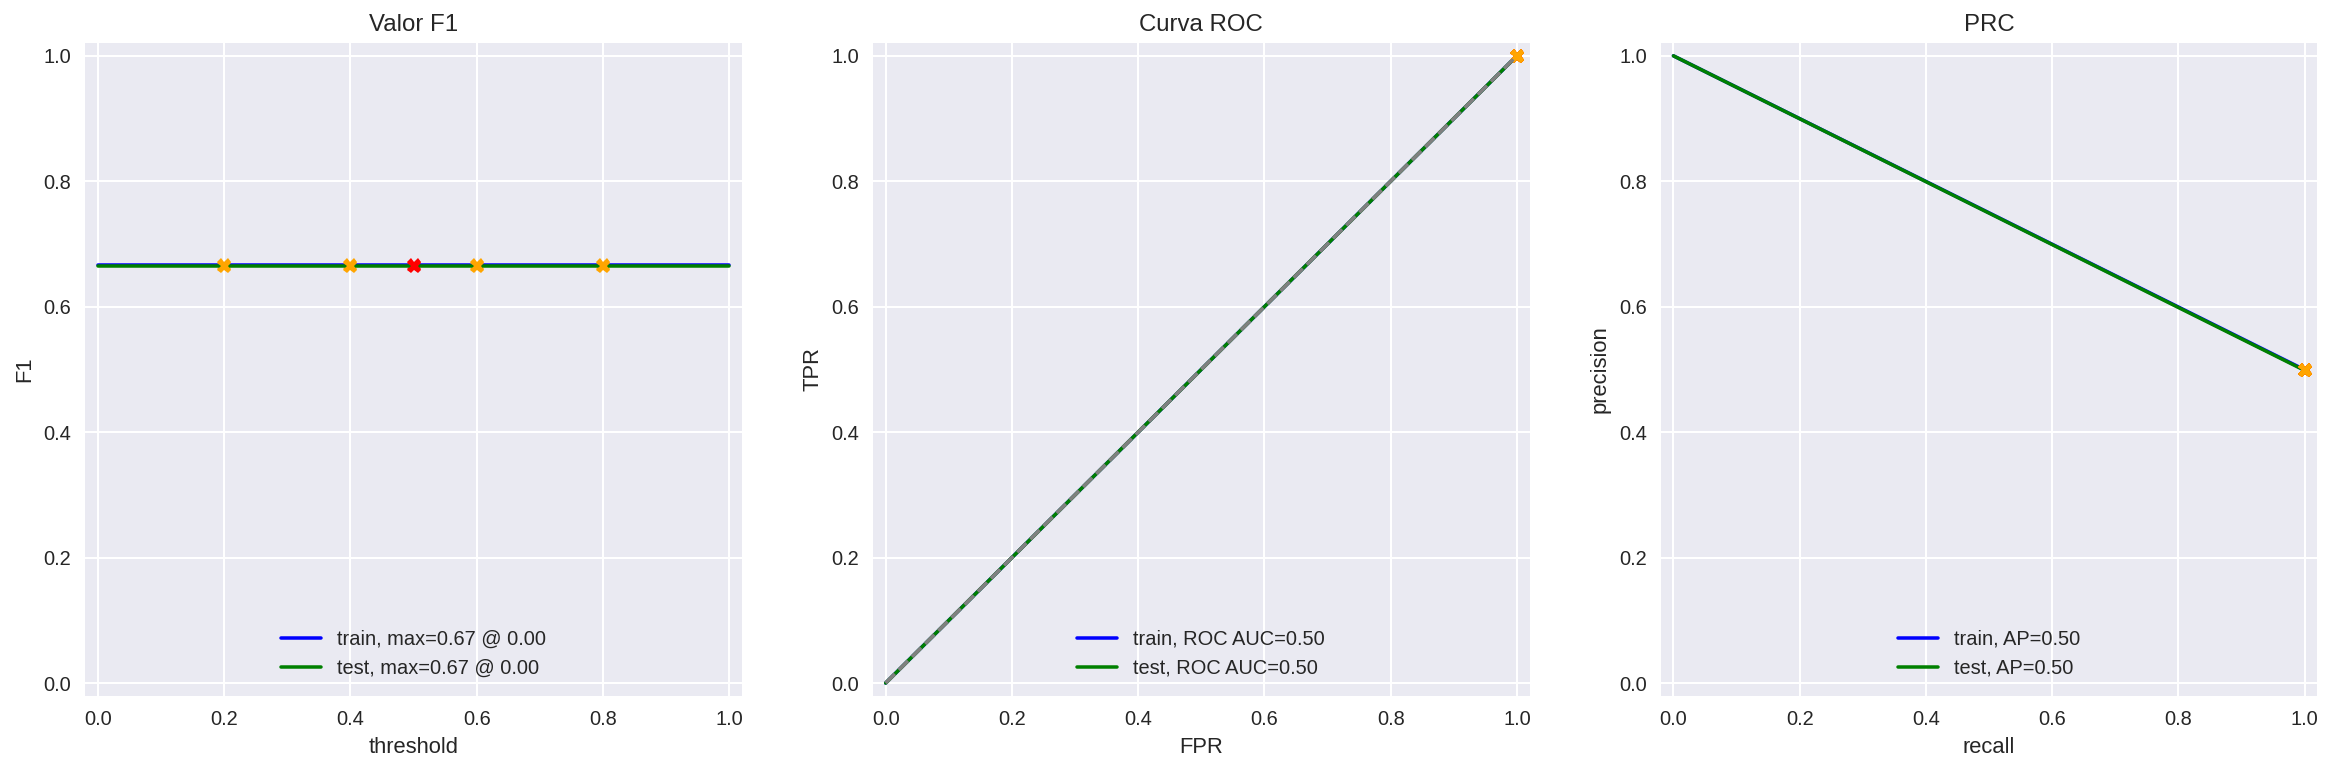

In [30]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

In [31]:
predicted_test_0 = model_0.predict(test_features_0)

In [32]:
from sklearn.metrics import f1_score
f1_0 = f1_score(test_target,predicted_test_0)
f1_0

0.6652865609846014

O F1 para o modelo 0 foi de 0.66. Abaixo do requerido pelo projeto.      

**Rascunho inicio**

In [35]:
encoder = LabelEncoder()
reviews_ordinal_train = df_reviews_train
reviews_ordinal_train['title_type'] = encoder.fit_transform(reviews_ordinal_train['title_type'])
reviews_ordinal_train['original_title'] = encoder.fit_transform(reviews_ordinal_train['original_title'])
reviews_ordinal_train['genres'] = encoder.fit_transform(reviews_ordinal_train['genres'])
reviews_ordinal_train['sp'] = encoder.fit_transform(reviews_ordinal_train['sp'])
reviews_ordinal_train = reviews_ordinal_train.drop(['tconst','primary_title','review','ds_part','idx','is_adult'], axis=1)
display(reviews_ordinal_train)

,title_type,original_title,start_year,runtime_minutes,genres,average_rating,votes,rating,sp,pos,review_norm
0,0,0,1971,121,199,6.3,2218,1,0,0,the pakage implies that warren beatty and gold...
1,0,0,1971,121,199,6.3,2218,1,0,0,how the hell did they get this made presenting...
7,0,1,1943,88,346,6.1,1240,2,0,0,this true story of carlson's raiders is more o...
8,0,1,1943,88,346,6.1,1240,2,0,0,should have been titled 'balderdash ' little i...
9,0,1,1943,88,346,6.1,1240,4,0,0,the movie 'gung ho ' the story of carlson's ma...
...,...,...,...,...,...,...,...,...,...,...,...
47253,0,2187,2001,104,64,5.2,3324,10,1,1,o my gosh just give me a minute to breath this...
47254,0,2187,2001,104,64,5.2,3324,10,1,1,i can't tell you all how much i love this movi...
47255,0,2187,2001,104,64,5.2,3324,10,1,1,legend of zu is possibly the most exciting mov...
47256,0,2187,2001,104,64,5.2,3324,10,1,1,this movie is well done on so many levels that...


In [36]:
encoder = LabelEncoder()
reviews_ordinal_test = df_reviews_test.copy()
reviews_ordinal_test['title_type'] = encoder.fit_transform(reviews_ordinal_test['title_type'])
reviews_ordinal_test['original_title'] = encoder.fit_transform(reviews_ordinal_test['original_title'])
reviews_ordinal_test['genres'] = encoder.fit_transform(reviews_ordinal_test['genres'])
reviews_ordinal_test['sp'] = encoder.fit_transform(reviews_ordinal_test['sp'])
reviews_ordinal_test = reviews_ordinal_test.drop(['tconst','primary_title','review','ds_part','idx','is_adult'], axis=1)
display(reviews_ordinal_test)


,title_type,original_title,start_year,runtime_minutes,genres,average_rating,votes,rating,sp,pos,review_norm
2,1,0,2002,25,219,6.3,184,3,0,0,there is no real story the film seems more lik...
3,1,0,2002,25,219,6.3,184,7,1,1,um a serious film about troubled teens in sing...
4,1,0,2002,25,219,6.3,184,9,1,1,i'm totally agree with garryjohal from singapo...
5,1,0,2002,25,219,6.3,184,9,1,1,this is the first movie i've seen from singapo...
6,1,0,2002,25,219,6.3,184,9,1,1,yes non singaporean's can't see what's the big...
...,...,...,...,...,...,...,...,...,...,...,...
47326,2,3343,1972,97,285,7.7,2254,10,1,1,this is another of my favorite columbos it spo...
47327,4,3344,1996,55,151,7.3,278,4,0,0,talk about being boring i got this expecting a...
47328,4,3344,1996,55,151,7.3,278,8,1,1,i never thought i'd say this about a biopic bu...
47329,4,3344,1996,55,151,7.3,278,9,1,1,spirit and chaos is an artistic biopic of miya...


In [107]:
train_features_00 = reviews_ordinal_train.drop(['pos','review_norm','sp','votes'] ,axis=1)
test_features_00 = reviews_ordinal_test.drop(['pos','review_norm','sp','votes'] ,axis=1)

In [38]:
train_target_00 = reviews_ordinal_train['pos']
test_target_00 = reviews_ordinal_test['pos']

In [39]:
from sklearn.linear_model import LogisticRegression

model_00 = LogisticRegression(random_state=54321, solver='liblinear')
model_00.fit(train_features_00,train_target_00)

LogisticRegression(random_state=54321, solver='liblinear')

          train  test
Accuracy    1.0   1.0
F1          1.0   1.0
APS         1.0   1.0
ROC AUC     1.0   1.0


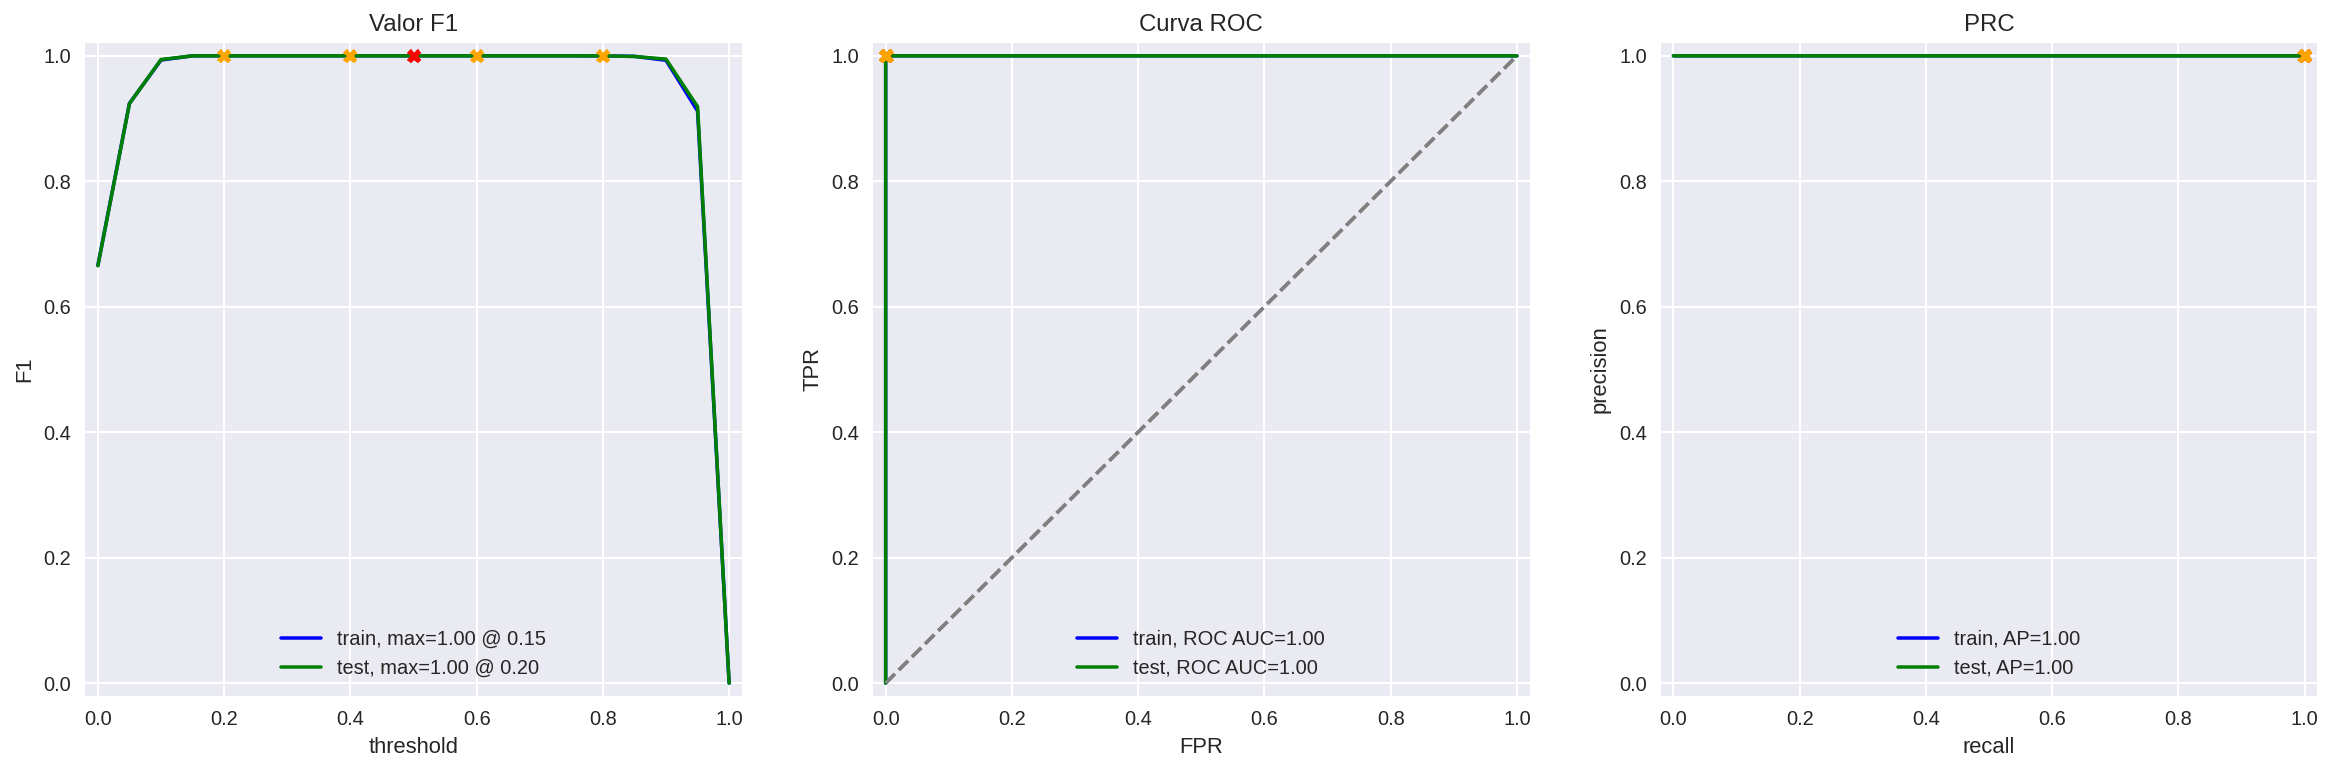

In [40]:
evaluate_model(model_00, train_features_00, train_target_00, test_features_00, test_target_00)

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
final_model = RandomForestClassifier(random_state=54321, n_estimators=10)

In [43]:
final_model.fit(train_features_00,train_target_00)

RandomForestClassifier(n_estimators=10, random_state=54321)

          train  test
Accuracy    1.0   1.0
F1          1.0   1.0
APS         1.0   1.0
ROC AUC     1.0   1.0


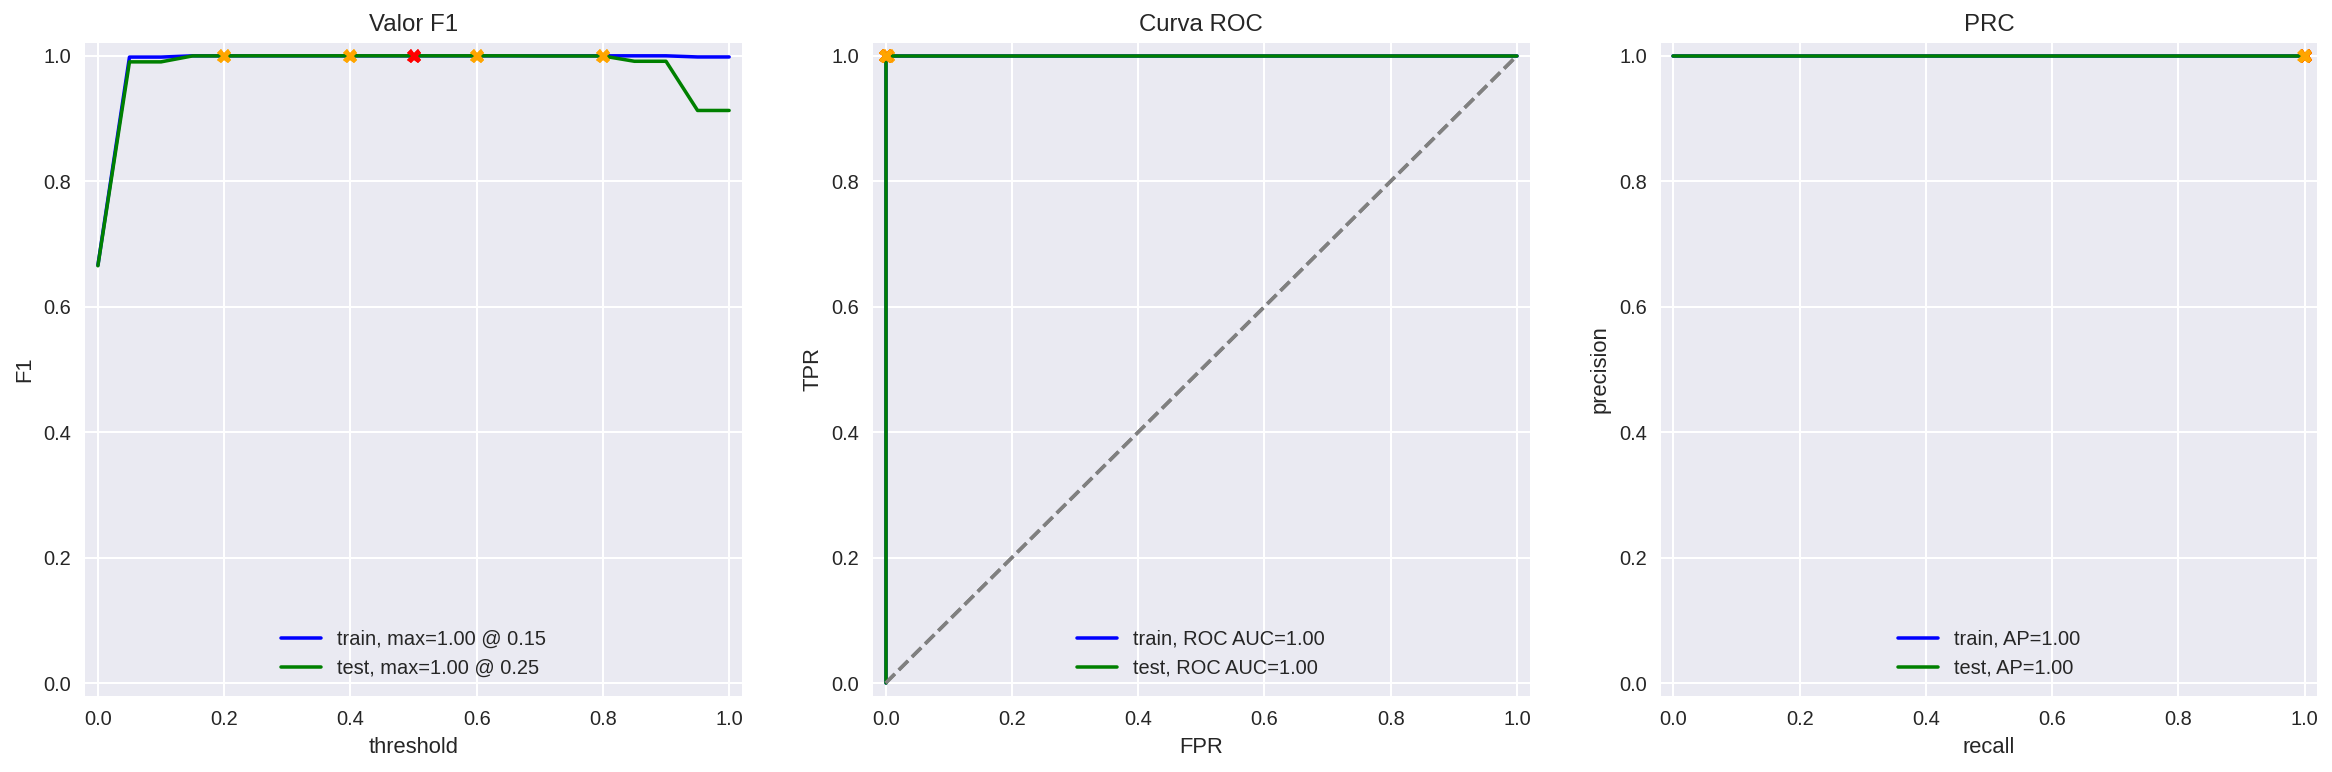

In [44]:
evaluate_model(final_model, train_features_00, train_target_00, test_features_00, test_target_00)

In [100]:
predicted_test_00 = final_model.predict(test_features_00)
predicted_test_00

array([0, 1, 1, ..., 1, 1, 1])

In [111]:
title_type = [0,0,4,4,5,1,2,3]
original_title = [2836,2836,777,1253,965,491,1196,1501]
start_year = [1999,2005,2001,2006,2004,2007,2008,1991]
runtime_minutes = [78,99,115,121,140,110,95,84]
genres = [322,197,322,364,23,87,92,264]
average_rating = [7.1,7.9,5.4,4.2,9.1,8.3,7.4,3.1]
rating =[7,8,4,3,8,1,9,2]
data = {'title_type':title_type,'original_title':original_title,'start_year':start_year,'runtime_minutes':runtime_minutes,'genres':genres,'average_rating':average_rating,'rating':rating}

In [112]:
feateus_testes = pd.DataFrame(data)
feateus_testes

,title_type,original_title,start_year,runtime_minutes,genres,average_rating,rating
0,0,2836,1999,78,322,7.1,7
1,0,2836,2005,99,197,7.9,8
2,4,777,2001,115,322,5.4,4
3,4,1253,2006,121,364,4.2,3
4,5,965,2004,140,23,9.1,8
5,1,491,2007,110,87,8.3,1
6,2,1196,2008,95,92,7.4,9
7,3,1501,1991,84,264,3.1,2


In [115]:
from lightgbm import LGBMClassifier
model_33 = LGBMClassifier()
model_33.fit(train_features_00,train_target_00)

LGBMClassifier()

In [117]:
predicted_test_013 = model_33.predict(test_features_00)
predicted_test_013

array([0, 1, 1, ..., 1, 1, 1])

In [118]:
f1_33 = f1_score(test_target_00,predicted_test_013)
f1_33

1.0

**Rascunho fim**

### Modelo 1 - NLTK, TF-IDF e Regressão Logística

TF-IDF

In [55]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

In [56]:
#Vetorizando  as resenhas normalizadas:
 
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_1  = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer_1.fit_transform(corpus_train)
test_features_1 = tfidf_vectorizer_1.transform(corpus_test)

In [57]:
model_1 = LogisticRegression(random_state=54321, solver='liblinear')
model_1.fit(train_features_1,train_target)

LogisticRegression(random_state=54321, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


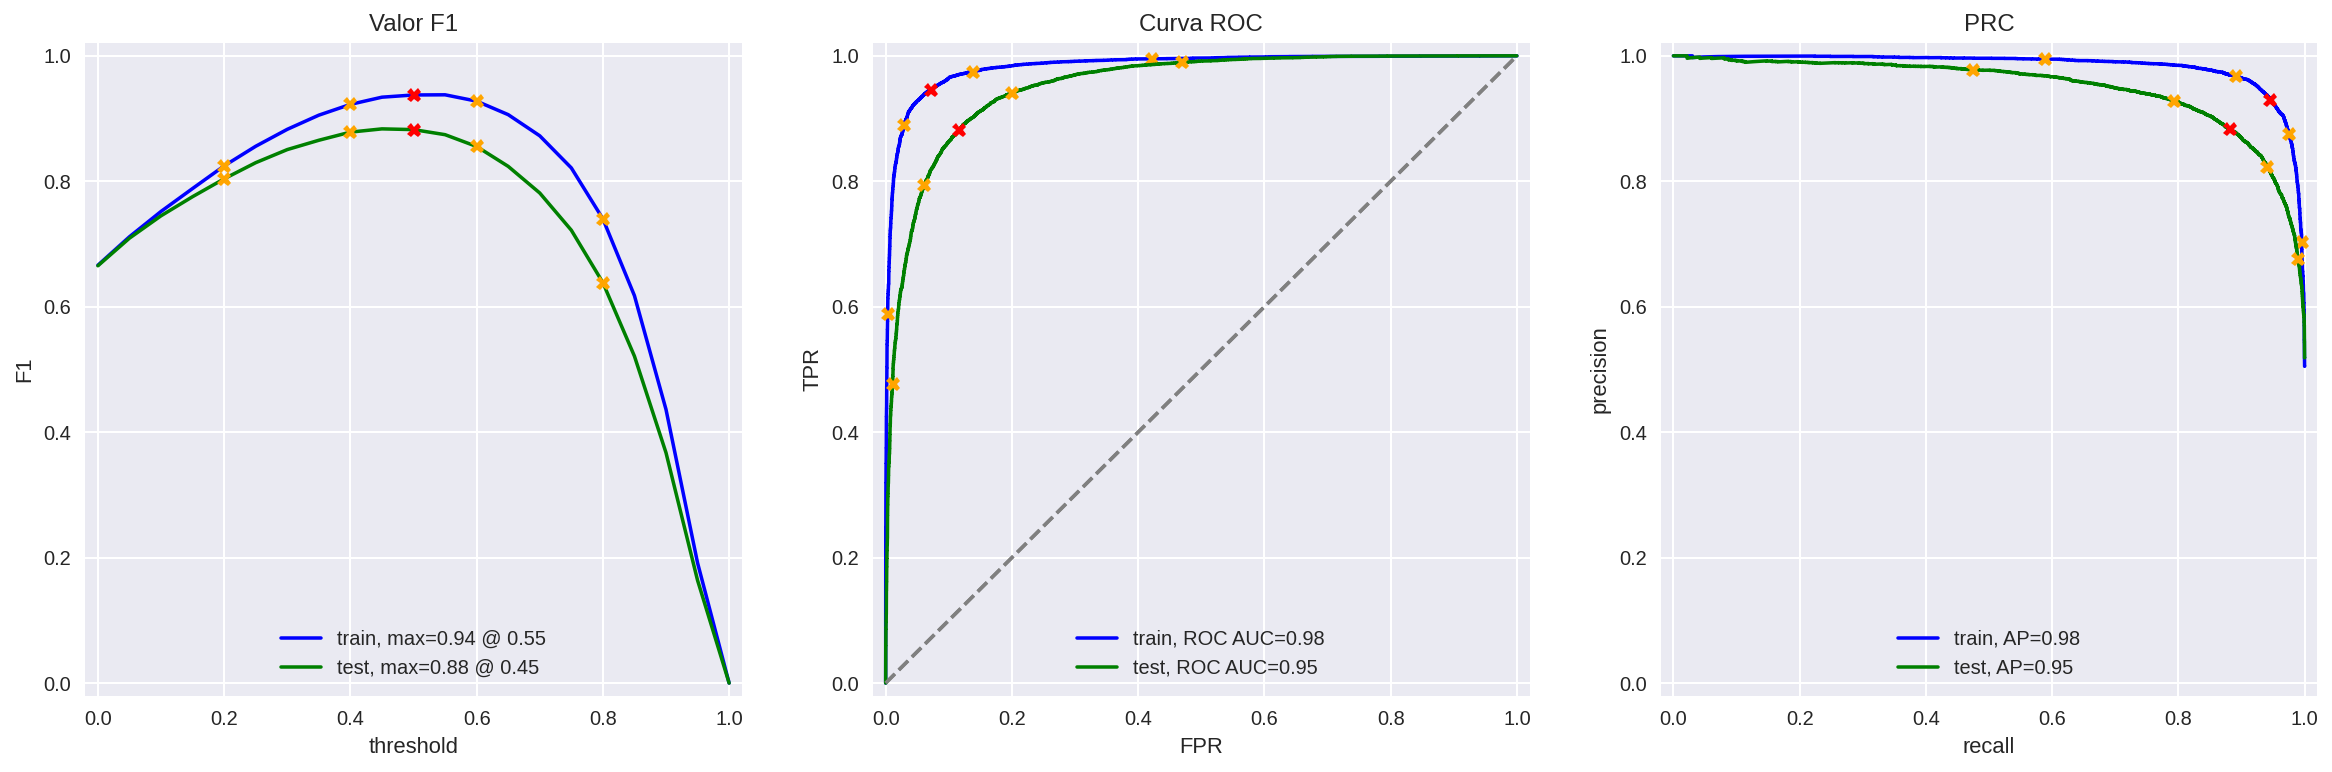

In [58]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [70]:
predicted_test_1 = model_1.predict(test_features_1)

In [71]:
f1 = f1_score(test_target,predicted_test_1)
f1

0.8823755279662102

O F1 para o modelo 1 foi de 0.88. Superior ao requerido pelo projeto (0.85).      

### Modelo 2 - spaCy, TF-IDF e Regressão Logística

In [39]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
#Função para lematizar as resenhas normalizadas:

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [41]:
df_reviews_train['review_lem'] = df_reviews_train['review_norm'].progress_apply(lambda x:text_preprocessing_3(x)) 
df_reviews_test['review_lem'] = df_reviews_test['review_norm'].progress_apply(lambda x:text_preprocessing_3(x)) 

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [42]:
#Vetorizando  as resenhas lematizadas:
corpus_train_2 = df_reviews_train['review_lem']
corpus_test_2 = df_reviews_test['review_lem']

stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words) 
train_features_2 =  tfidf_vectorizer_2.fit_transform(corpus_train_2)
test_features_2 = tfidf_vectorizer_2.transform(corpus_test_2)



In [43]:
model_2 = LogisticRegression(random_state=54321, solver='liblinear')
model_2.fit(train_features_2,train_target)

LogisticRegression(random_state=54321, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


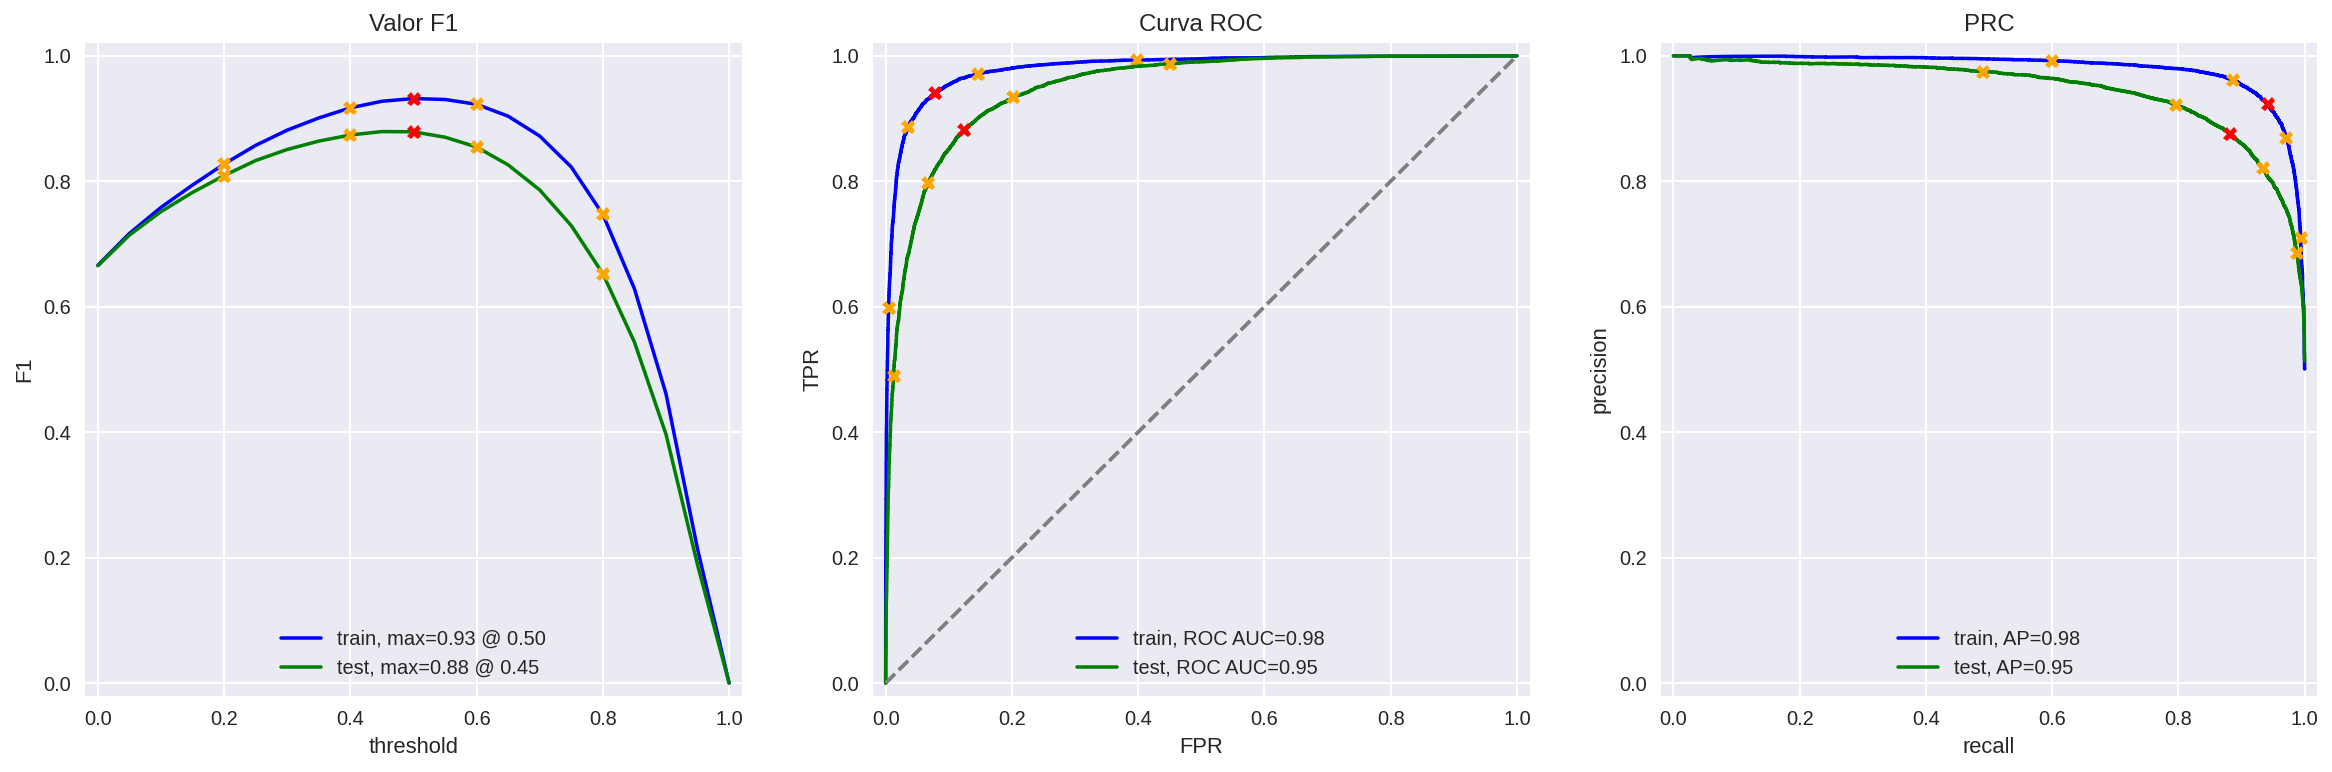

In [44]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

In [45]:
predicted_test_2 = model_2.predict(test_features_2)
f1_2 = f1_score(test_target,predicted_test_2)
f1_2

0.8788818556438251

O F1 para o modelo 2 foi de 0.878. Superior ao requerido pelo projeto (0.85).      

### Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

In [46]:
from lightgbm import LGBMClassifier

In [47]:
model_3 = LGBMClassifier()
model_3.fit(train_features_2,train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


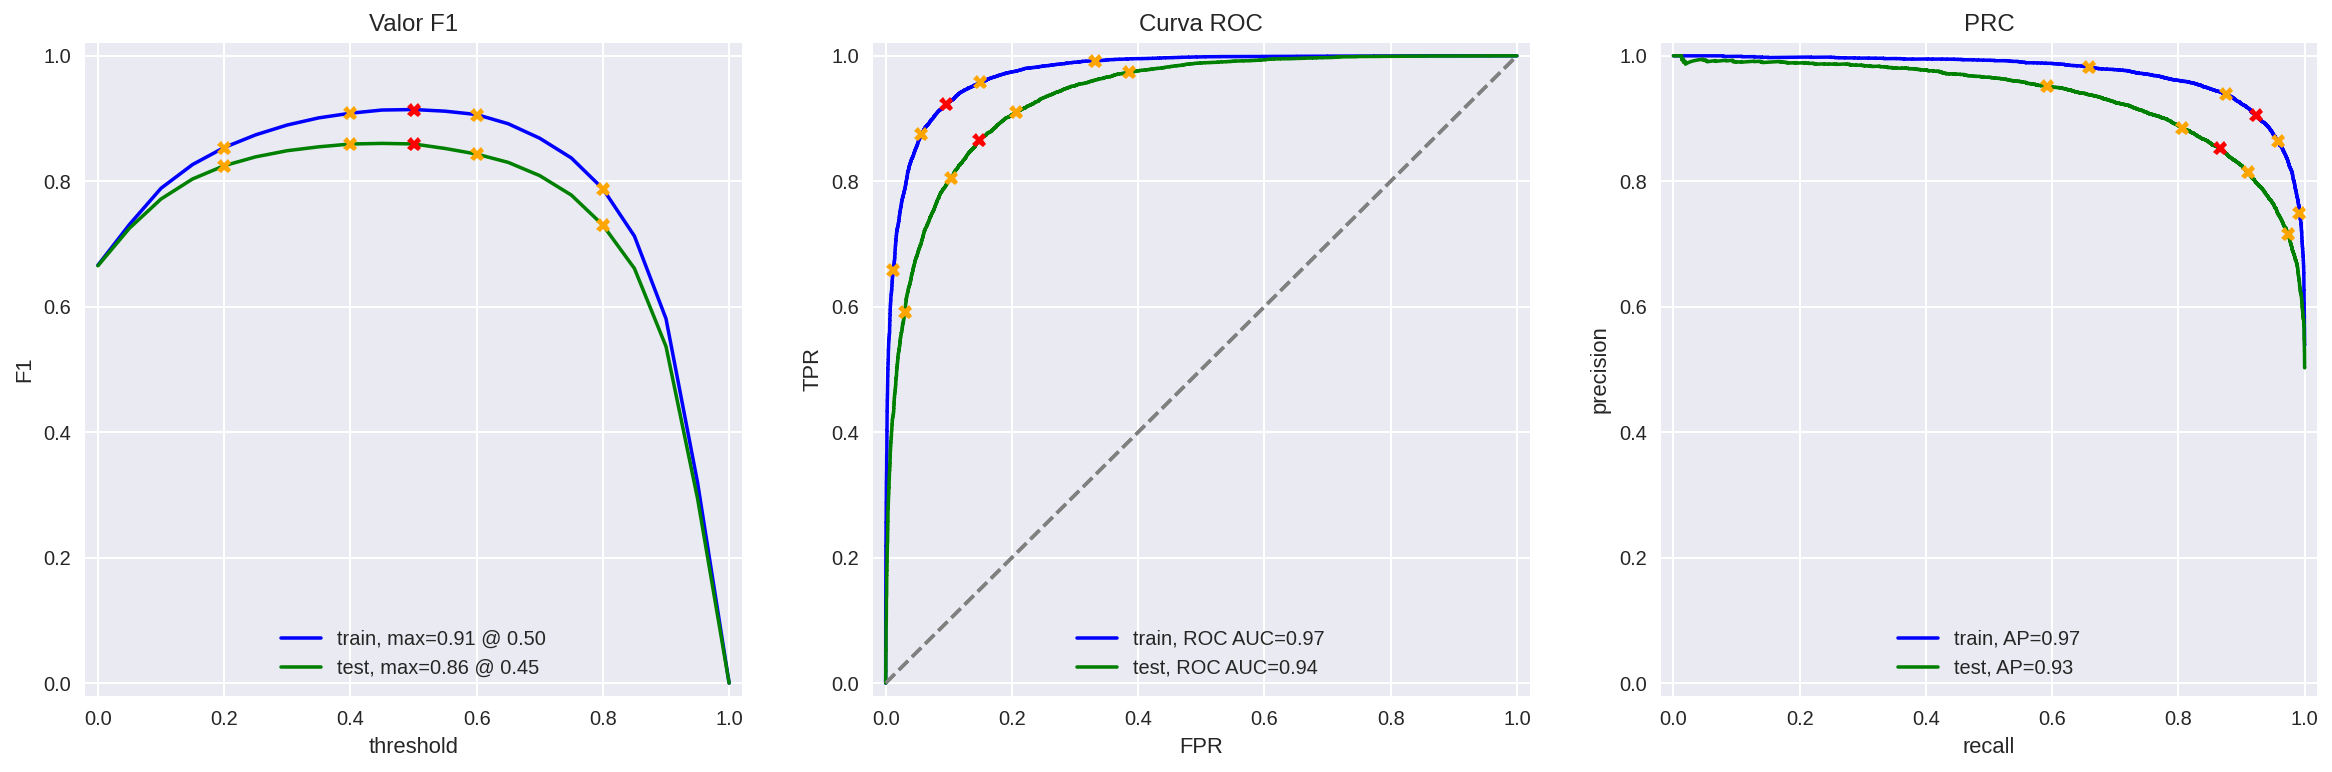

In [48]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

In [49]:
predicted_test_3 = model_3.predict(test_features_2)
f1_3 = f1_score(test_target,predicted_test_3)
f1_3

0.8595244139798596

O F1 para o modelo 3 foi de 0.859. Superior ao requerido pelo projeto (0.85).      

###  Modelo 9 - BERT

Acabei não testanto esse modelo, pois estava demorando muito.

In [50]:
import torch
import transformers

In [51]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção
    ids = texts.apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=max_length))
    padded = ids.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    attention_mask = padded.apply(lambda x: np.where(x != 0, 1, 0))
    
    
    # <coloque seu código aqui para criar ids_list e attention_mask_list>
    ids_list = padded
    attention_mask_list = attention_mask
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')
    
    # recebendo incorporações em lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <coloque seu código aqui para criar attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

## Minhas Resenhas

In [54]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'This is the worst movie i ever watch.',
    'this is the best movie i ever watch. ',
    'this show is not good, but it is not bad',
    'this show is ok!'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x:clear_text(x))  # <coloque aqui a mesma lógica de normalização do conjunto de dados principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,This is the worst movie i ever watch.,this is the worst movie i ever watch
8,this is the best movie i ever watch.,this is the best movie i ever watch
9,"this show is not good, but it is not bad",this show is not good but it is not bad


### Modelo 1

In [55]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.00:  this is the worst movie i ever watch
0.97:  this is the best movie i ever watch
0.04:  this show is not good but it is not bad
0.17:  this show is ok


### Modelo 2

In [56]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.00:  this is the worst movie i ever watch
0.87:  this is the best movie i ever watch
0.03:  this show is not good but it is not bad
0.24:  this show is ok


### Modelo 3

In [57]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.42:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.63:  i didn't expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.24:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.10:  this is the worst movie i ever watch
0.81:  this is the best movie i ever watch
0.28:  this show is not good but it is not bad
0.50:  this show is ok


### Modelo 9

Não treinei esse modelo. 

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusões

In [58]:
F1_modelos =[f1_0,f1,f1_2,f1_3]
F1_modelos

[0.6652865609846014,
 0.8823755279662102,
 0.8788818556438251,
 0.8595244139798596]

In [59]:
modelos = ['Modelo 0','Modelo 1','Modelo 2','Modelo 3']
modelos

['Modelo 0', 'Modelo 1', 'Modelo 2', 'Modelo 3']

In [60]:
resultados = pd.DataFrame( 
    {'Model F1' : F1_modelos
    },
    index = modelos)
resultados

,Model F1
Modelo 0,0.665287
Modelo 1,0.882376
Modelo 2,0.878882
Modelo 3,0.859524


O modelo com maior F1 foi o modelo 1: NLTK, TF-IDF e Regressão Logística. Logo pode ser a escolha ideal para prevermos se uma resenha é positiva ou negativa. 

Analisando os resultados com as resenhas que escrevi cheguei a algumas conclusões:
- As resenhas que estavam escritas em português não trazem resultados bons. Todas as resenhas ficaram perto do 0.5 não importando se eram positivas ou negativas. Por isso, escrevi todas elas em inglês
- Os resultados dos modelos 1 e 2 foram bem semelhantes nessas resenhas testes. Achei curioso que os resultados do modelo 3 normalmente deram maiores em relação aos outros dois, como se percebesse sempre as resenhas como mais positivas do que negativas.
- Testando uma resenha mais neutra. O modelo 3 trouxe um melhor resultado que os outros 2. 



Analisando individualmente cada resenha, em alguns casos o modelo 3 foi mais adequado e em outros, o 1 e 2 foram melhores. Não vi muita diferença entre os modelos 1 e 2, ambos possuem f1 bem parecido e quando analisei individualmente trouxeram resultados bem semelhantes. Cheguei a conclusão que os modelos 1,2 e 3 são excelentes escolhas para a empresa Film Junky Union classificar as resenhas como positivas ou negativas.  
